In [1]:
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error

from oit_helpers2 import DataPreprocessors,LSTM,createDataLoader,getDataLoader

sns.set(style="darkgrid", font_scale=1.5)
%matplotlib inline

# Data Preprocessing

In [2]:
data_location = './datasets/all-crypto-currencies/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv'
data = (pd.read_csv(data_location,
                    index_col="Timestamp")
        .dropna(subset=['Close']))
data.index = pd.to_datetime(data.index, unit='s')
data.shape

(3613769, 7)

Counting the number of observations by year reveals that we have many recordings per day. Indeed, a look at the indices (timestamps) reveals that our data is measured on the minute. Since we're modeling closing price, we only want to keep the final recording of the day.

In [3]:
# How many data points per year
print('Obs per year',(data
                      .Close
                      .groupby(data.index.year)
                      .count()))

print('\nSample of indices',data.index[100:105])

Obs per year Timestamp
2011         4
2012     26629
2013    319761
2014    398176
2015    372735
2016    352099
2017    483332
2018    505773
2019    508340
2020    518895
2021    128025
Name: Close, dtype: int64

Sample of indices DatetimeIndex(['2012-01-10 09:57:00', '2012-01-10 09:58:00',
               '2012-01-10 09:59:00', '2012-01-10 10:00:00',
               '2012-01-10 10:42:00'],
              dtype='datetime64[ns]', name='Timestamp', freq=None)


In [4]:
# Take last daily recording as Closing cost
data = (data
        .groupby(data.index.date)
        .Close
        .last())
data.index = pd.to_datetime(data.index)
data.shape

(3376,)

After keeping the final recording of the day, the number of observations per year are closer to what we'd expect.

In [5]:
# How many data points per year
(data
 .groupby(data.index.year)
 .count())

2011      1
2012    366
2013    365
2014    365
2015    362
2016    366
2017    365
2018    365
2019    365
2020    366
2021     90
Name: Close, dtype: int64

It seems that closing price was fairly low and flat for the first ~5 years of data as is obvious by the long tail. The time series shows much more dynamic behavior starting in 2017 when Bitcoin prices started rising. Beginning in 2020, the closing price exploded. To remove "noise", we will drop information from the long tail, which is uncharacteristic of current Bitcoin behavior.

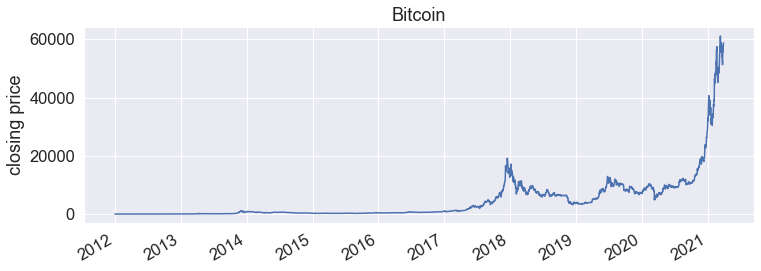

In [6]:
data.plot(figsize=(12, 4))
plt.ylabel("closing price")
plt.title("Bitcoin")
plt.show()

## Load preprocessor object for further data preprocessing

In [7]:
# our custom preprocessor class
dprep = DataPreprocessors(data=pd.DataFrame(data))

Data before 2017 is dropped, and we ensure that we have at least one recording per day. If not (i.e., if we have missing data), we use a fill forward approach where the last non-missing value in the series is used to impute the missing price.

This leaves us with 1551 Bitcoin closing prices ranging from 2017-01-01 to 2021-03-31.

In [8]:
df_bc = dprep.ensure_equal_timeseries(min_date='2017-01-01',
                                      max_date='2021-03-31')
df_bc.shape

Results in 0 missing elements


(1551, 1)

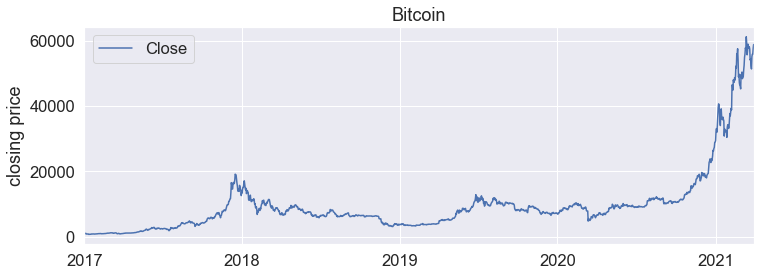

In [9]:
df_bc[['Close']].plot(figsize=(12, 4))
plt.ylabel("closing price")
plt.title("Bitcoin")
plt.show()

## Prepare lagged dataset

To forecast Bitcoin prices, we will first create a new dataset in which we used lagged values to predict the next price in the series. That is, given the 1551 closing price data points, we will choose a timestep or lag value `n_lags` that defines the number of consecutive time points we will use to predict the next value. This "window" of length `n_lags` is then slide one unit across, and the next value in the series becomes the new target of prediction.

In [10]:
n_lags = 7+1
lagged_data = dprep.create_timeseries_sequences(data=df_bc, 
                                                timestep=n_lags)

## Train test split

For brevity, we only use a train/test split and omit a validation set for now. 

For the historical data `x`, the first dimension ("rows") represents the sequences of length `n_lags`, and the second dimension ("columns") correspond to each of the `n_lags` measurements.

For the target data `y`, the first dimension ("rows") represents the measurements that are predicted from the associated sequences or "rows" in `x`. Within a training/test set, the first dimension should match.

In [11]:
x_train, y_train, x_test, y_test = dprep.train_test_split(lagged_data=lagged_data,
                                                          prop_test=.1)

x_train.shape =  (1389, 7, 1)
y_train.shape =  (1389, 1)
x_test.shape =  (154, 7, 1)
y_test.shape =  (154, 1)


To speed up and improve training, we normalize the data using the MinMax approach with min/max values of -1 and 1, respectively. Importantly, we only use the training data when initializing the scaler--test data is only transformed using the scaler object from the training data.

In [12]:
# Scaler expects 2D, so we remove (squeeze) the last dimension for the moment
x_train, scaler_ = dprep.normalize_data(x_train.squeeze(2), train = True)
y_train, scaler__ = dprep.normalize_data(y_train, train=True)

# Only transform the test data
x_test, _ = dprep.normalize_data(x_test.squeeze(2), scaler_)
y_test, _ = dprep.normalize_data(y_test, scaler__)

In [13]:
# Add the third dimension back in as expected by LSTM model
x_train = np.expand_dims(x_train,axis=2)
x_test = np.expand_dims(x_test,axis=2)

In [14]:
# Convert to tensors as required by PyTorch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

## Train the LSTM

### Initialize model, define hyperparameters, loss function and optimization alogrithm

Setting preliminary values, but different values should be explored.

In [15]:
# Set hyperparameters
#####################

hidden_layer_size = 100
n_layers = 2
learning_rate = 0.01
n_epochs = 200
do = 0

In [16]:
# Build model
#####################

input_size = 1
output_size = 1

model = LSTM(input_size=input_size, 
               hidden_layer_size=hidden_layer_size, 
               n_layers=n_layers, 
               output_size=output_size)

print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 100, num_layers=2, batch_first=True)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)
10
torch.Size([400, 1])
torch.Size([400, 100])
torch.Size([400])
torch.Size([400])
torch.Size([400, 100])
torch.Size([400, 100])
torch.Size([400])
torch.Size([400])
torch.Size([1, 100])
torch.Size([1])


In [17]:
# Loss function and optimization algorithm
#####################

loss_fn = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate)

### Train the model

In [18]:
# Train model
#####################
hist = np.zeros(n_epochs)

# Number of steps to unroll
seq_dim = n_lags - 1  

for epoch in range(n_epochs):    
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if epoch % 10 == 0 and epoch !=0:
        print("Epoch ", epoch, "MSE: ", loss.item())
    hist[epoch] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.04260166734457016
Epoch  20 MSE:  0.014857346192002296
Epoch  30 MSE:  0.007718811277300119
Epoch  40 MSE:  0.004638992715626955
Epoch  50 MSE:  0.0037118878681212664
Epoch  60 MSE:  0.003246524604037404
Epoch  70 MSE:  0.00290318438783288
Epoch  80 MSE:  0.002656869124621153
Epoch  90 MSE:  0.0024909847415983677
Epoch  100 MSE:  0.0023300701286643744
Epoch  110 MSE:  0.0021811213809996843
Epoch  120 MSE:  0.00205070897936821
Epoch  130 MSE:  0.001940534682944417
Epoch  140 MSE:  0.0018450614297762513
Epoch  150 MSE:  0.002238383051007986
Epoch  160 MSE:  0.001819800236262381
Epoch  170 MSE:  0.0017583868466317654
Epoch  180 MSE:  0.0016540741780772805
Epoch  190 MSE:  0.0016190973110496998


## Evaluate performance

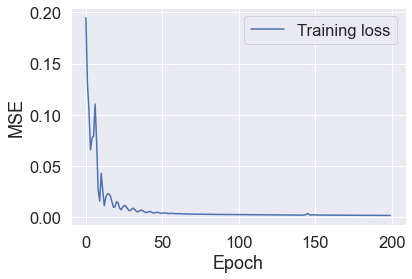

In [19]:
plt.plot(hist, label="Training loss")
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

### Evaluate on test set

Since the targets were also scaled, predictions are first back-transformed to their original scale.

In [20]:
y_test_pred = model.predict(x_test)

# invert predictions
y_train_pred = scaler__.inverse_transform(y_train_pred.detach().numpy())
y_train_ = scaler__.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler__.inverse_transform(y_test_pred.detach().numpy())
y_test_ = scaler__.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train_[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test_[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 367.04 RMSE
Test Score: 8943.56 RMSE


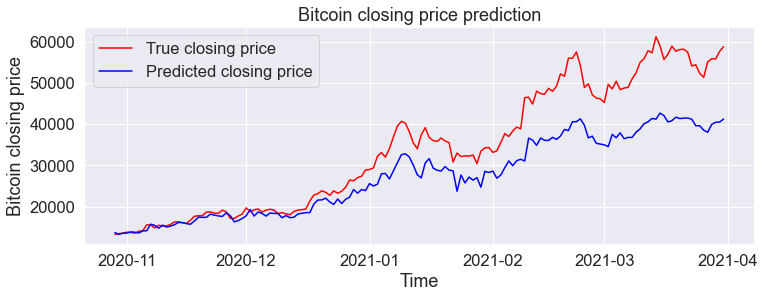

In [23]:
# Visualising the results
figure, axes = plt.subplots(figsize=(12, 4))
axes.xaxis_date()
axes.plot(df_bc[len(df_bc)-len(y_test_):].index, y_test_, color = 'red', label = 'True closing price')
axes.plot(df_bc[len(df_bc)-len(y_test_):].index, y_test_pred, color = 'blue', label = 'Predicted closing price')
plt.title('Bitcoin closing price prediction')
plt.xlabel('Time')
plt.ylabel('Bitcoin closing price')
plt.legend()
plt.show()

## Persist the model

In [ ]:
torch.save(model.state_dict(), 'base_lstm.pth')

## Load trained model

Testing loading of the model. To simulate, clear the kernel so no objects are in the current environment. By loading the trained model and testing prediction, we verify that we have a working (trained) model.

In [2]:
import torch
from oit_helpers2 import LSTM

In [3]:
# Initialize the model object
hidden_layer_size = 100
n_layers = 2
input_size = 1
output_size = 1

model = LSTM(input_size=input_size, 
               hidden_layer_size=hidden_layer_size, 
               n_layers=n_layers, 
               output_size=output_size)

In [5]:
# Load the trained model parameters and associate with empty LSTM model
with torch.no_grad():
    save_path = "./base_lstm.pth"
    model.load_state_dict(torch.load(save_path))
    model.eval() # since we're not computing gradients
    test = torch.rand(30,7,1)
    preds = model(test)

In [8]:
#model.state_dict()['lstm.weight_ih_l0']

## Future development
- Tune hyperparameters (including n_lags, amount of data, NN parameters [layers, hidden nodes], learning rate, etc.)
- By hand, but better done through cross-validation and with a validation set